# Imaging notebook

This notebook works through the high level functions interface to crocodile, making a fake data set and then
deconvolving it. Finally the full and residual visibility are plotted.

In [19]:
%matplotlib inline

import sys, os 
sys.path.append('../..') 
print(os.getcwd())

import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

from astropy import constants as const
from astropy.coordinates import SkyCoord, CartesianRepresentation, SkyOffsetFrame
import scipy.special

from matplotlib import pylab
from matplotlib import pyplot as plt

from functions.clean import clean

from functions.imaging import *
from functions.skymodel import SkyModel, skymodel_add_image, skymodel_add_component
from functions.image import image_show, image_from_fits, image_replicate
from functions.configuration import configuration_filter, named_configuration


/Users/timcornwell/Code/crocodile/examples/notebooks


We construct a VLA configuration and then shrink it to match our test image.

In [20]:
kwargs = {}

vlaa = configuration_filter(named_configuration('VLAA'), **kwargs)
vlaa.data['xyz']=vlaa.data['xyz']/10.0

Configuration: No filter implemented yet


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [21]:
times = numpy.arange(-numpy.pi/2.0, +numpy.pi/2.0,0.05)
frequency = numpy.arange(1.0e8, 1.50e8, 1e7)

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(0.0*u.rad, u.rad*numpy.pi/4, frame='icrs', equinox=2000.0)
vt = simulate(vlaa, times, frequency, weight=1.0, phasecentre=phasecentre)

visibility.simulate: Created 22113 rows


Plot the synthesized uv coverage, including for MFS

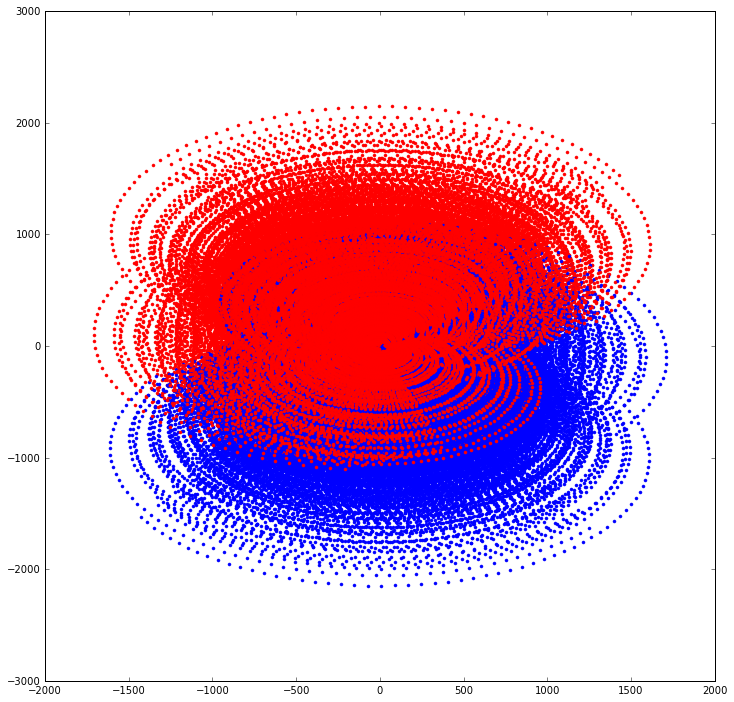

In [22]:
plt.clf()
for f in frequency:
    x=f/const.c
    plt.plot(x*vt.data['uvw'][:,0], x*vt.data['uvw'][:,1], '.', color='b')
    plt.plot(-x*vt.data['uvw'][:,0], -x*vt.data['uvw'][:,1], '.', color='r')

Read the venerable test image, constructing an image

image_from_fits: Max, min in /Users/timcornwell/Code/crocodile//./data/models/m31.MOD = 1.006458, -0.000000


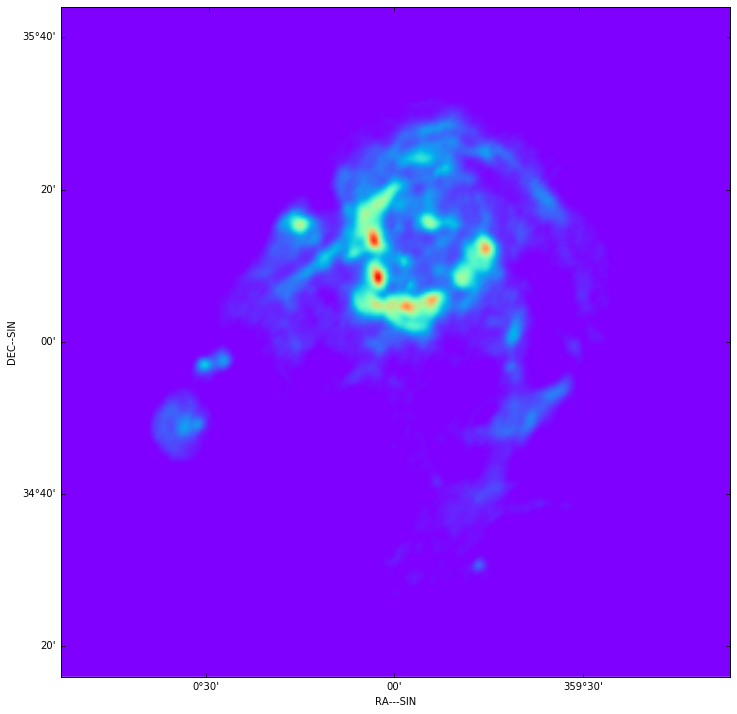

In [23]:
m31image = image_from_fits("./data/models/m31.MOD")
fig = plt.figure()
cellsize=180.0*0.0001/numpy.pi
m31image.wcs.wcs.cdelt[0]=-cellsize
m31image.wcs.wcs.cdelt[1]=+cellsize
m31image.wcs.wcs.radesys='ICRS'
m31image.wcs.wcs.equinox=2000.00


fig.add_subplot(111, projection=m31image.wcs)
plt.imshow(m31image.data, origin='lower', cmap='rainbow')
plt.xlabel('RA---SIN')
plt.ylabel('DEC--SIN')
plt.show()

In [17]:
from astropy.wcs.utils import skycoord_to_pixel, pixel_to_skycoord
wall = m31image.wcs
wall.wcs.radesys='ICRS'
wall.wcs.equinox=2000.00
print(wall.wcs.radesys)
print(wall.wcs.equinox)
sc=pixel_to_skycoord(128, 128, wall, 1, 'wcs')
print(sc)
pixloc = skycoord_to_pixel(SkyCoord("-1.0d", "37.0d", frame='icrs', equinox=2000.0), wall, 1)
print(pixloc)
scrt = pixel_to_skycoord(pixloc[0], pixloc[1], wall, 1, 'wcs')
print(scrt)


ICRS
2000.0
<SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 35.0)>
(array(267.38111516593335), array(477.69264278296))
<SkyCoord (ICRS): (ra, dec) in deg
    (359.0, 37.0)>


In [26]:
sof=sc.skyoffset_frame()

In [26]:
m31image4D=image_replicate(m31image, shape=[1, 1, 4, len(frequency)])
m31sm = skymodel_from_image(m31image4D)

image_replicate: replicating shape (256, 256) to (5, 4, 256, 256)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 0.0  35.0  
CRPIX : 128.0  128.0  
NAXIS    : 256 256


Add some SkyComponents

In [22]:
comp1=SkyComponent(SkyCoord("05d00m00.0s", "02d00m0.0s"), [1.0,0.0,0.0,0.0], frequency)
m31sm=skymodel_add_component(m31sm, comp1)

Now we can predict the visibility from this model

In [32]:
kwargs={'wstep':100.0, 'npixel':256, 'cellsize':0.0002}
vt = predict(vt, m31sm, **kwargs)

imaging.wcs_from_visibility: Parsing kwargs to get definition of WCS
imaging.wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    (0.0, 45.0)>, frequency 140000000.0 Hz Hz, and bandwidth 10000000.0 Hz Hz
imaging.wcs_from_visibility: uvmax = 2147.256313 lambda
imaging.wcs_from_visibility: Critical cellsize = 0.000233 radians, 0.013342 degrees
imaging.wcs_from_visibility: Cellsize          = 0.000200 radians, 0.011459 degrees
imaging.predict: Predicting Visibility from sky model images
imaging.predict: Making w-kernel cache of 16 kernels
imaging.predict: Predicting from image channel 0, polarisation 0


../../crocodile/synthesis.py:105: RuntimeWarning: invalid value encountered in sqrt
  ph = w * (1 - numpy.sqrt(1 - l ** 2 - m ** 2))


ValueError: operands could not be broadcast together with shapes (31,14) (31,31) 

To check that we got it right, plot the amplitude of the visibility.

This image is only 2 dimensional. We need extra axes frequency and stokes. 

In [ ]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

In [ ]:
kwargs={}
kwargs['npixel']=512
kwargs['cellsize']=0.0004
kwargs['wstep']=30.0
dirty, psf, sumwt = invert(vt, **kwargs)
image_show(dirty)
print("Max, min in dirty image = %.6f, %.6f, sum of weights = %f" % (dirty.data.max(), dirty.data.min(), sumwt))
image_to_fits(dirty, 'dirty.fits')
image_to_fits(psf, 'psf.fits')
m31smnew, res = fitcomponent(dirty, m31sm, **kwargs)

In [ ]:
kwargs={'niter':1000}
comp, residual = clean(dirty, psf, **kwargs)

In [ ]:
fig=image_show(comp)
fig=image_show(residual)

In [ ]:
kwargs={'wstep':30.0}
vt = predict(vt, m31sm, **kwargs)
modelsm=skymodel_from_image(comp)
vtmodel = simulate(vlaa, times, frequency, weight=1.0, direction=direction)
vtmodel.data = vt.data.copy()
vtmodel=predict(vtmodel, modelsm,**kwargs)

In [ ]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]), '.', color='b')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:,0,0]-vtmodel.data['vis'][:,0,0]), '.', color='r')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()